In [ ]:
import numpy as np
from scipy import optimize
!pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import jax
import jax.numpy as jnp
from ott.geometry.pointcloud import PointCloud
from ott.tools.plot import Plot
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.problems.linear import linear_problem
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython import display

In [ ]:
def plot_epsilons_anim(n: int, epsilons: jnp.array = [0.0, 1e-3, 1e-2]):
  titles = []
  outs = []
  dim = 2
  rngs = jax.random.split(jax.random.PRNGKey(0),3)
  x = jax.random.uniform(rngs[0],(n,dim))
  y = jax.random.uniform(rngs[1],(n,dim))
  for i, epsilon in enumerate(epsilons):
    geom = PointCloud(x,y, epsilon=epsilon)
    if epsilon == 0.0:
      lines, cols = optimize.linear_sum_assignment(geom.cost_matrix)
      matrix = jnp.eye(n)[:,jnp.argsort(cols)] / n
      OT = namedtuple('OT', 'matrix geom a b')
      outs.append(OT(matrix, geom, jnp.ones((n,))/n, jnp.ones((n,))/n))
    else:
      outs.append(sinkhorn.solve(geom, max_iterations=1e5))
    titles.append(r'$\gamma$ = ' + "{:.5f}".format(epsilon))
    fig = plt.figure(figsize=(8, 5))
    plott = Plot(fig=fig, threshold=1e-9, title=titles[-1])
    plott(outs[-1])
    plt.savefig("eps"+str(i)+".png")
    plt.close()
    plt.imshow(outs[-1].matrix)
    plt.title(titles[-1])
    plt.clim(0, 1/n)
    plt.savefig("p_star"+str(i)+".png")
    plt.close

  fig = plt.figure(figsize=(8, 5))
  plott = Plot(fig=fig, threshold=1e-9)
  anim = plott.animate(outs, frame_rate=1, titles=titles)
  html = display.HTML(anim.to_jshtml())
  display.display(html)
  plt.close()


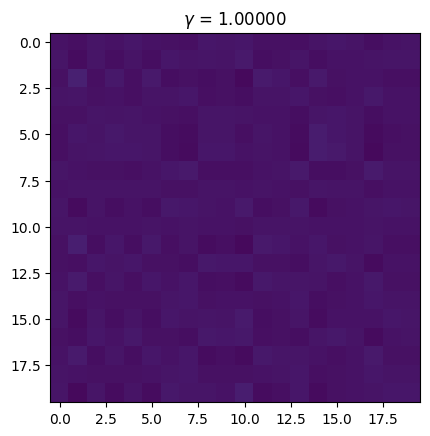

In [ ]:
step = .5
epsilons = 10 ** jnp.arange(-4,step,step)
epsilons = jnp.concatenate((jnp.array([0.0,]),epsilons))
anim = plot_epsilons_anim(20, epsilons)

In [ ]:
def plot_lr_anim(n: int, ranks: jnp.array = [15, 10, 5]):
  titles = []
  outs = []
  dim = 2
  rngs = jax.random.split(jax.random.PRNGKey(0),3)
  x = jax.random.uniform(rngs[0],(n,dim))
  y = jax.random.uniform(rngs[1],(n,dim))
  for i, rank in enumerate(ranks):
    geom = PointCloud(x,y)
    if rank == -1:
      lines, cols = optimize.linear_sum_assignment(geom.cost_matrix)
      matrix = jnp.eye(n)[:,jnp.argsort(cols)] / n
      OT = namedtuple('OT', 'matrix geom a b')
      outs.append(OT(matrix, geom, jnp.ones((n,))/n, jnp.ones((n,))/n))
    else:
      ot_prob = linear_problem.LinearProblem(geom)
      solver = sinkhorn_lr.LRSinkhorn(rank=rank)
      outs.append(solver(ot_prob))
    titles.append(r'$r$ = ' + str(rank))
    fig = plt.figure(figsize=(8, 5))
    plott = Plot(fig=fig, threshold=1e-9, title=titles[-1])
    plott(outs[-1])
    plt.savefig("rank"+str(i)+".png")
    plt.close()
    plt.imshow(outs[-1].matrix)
    plt.title(titles[-1])
    plt.clim(0, 1/n)
    plt.savefig("p_rank"+str(i)+".png")
    plt.close

  fig = plt.figure(figsize=(8, 5))
  plott = Plot(fig=fig, threshold=1e-9)
  anim = plott.animate(outs, frame_rate=1, titles=titles)
  html = display.HTML(anim.to_jshtml())
  display.display(html)
  plt.close()


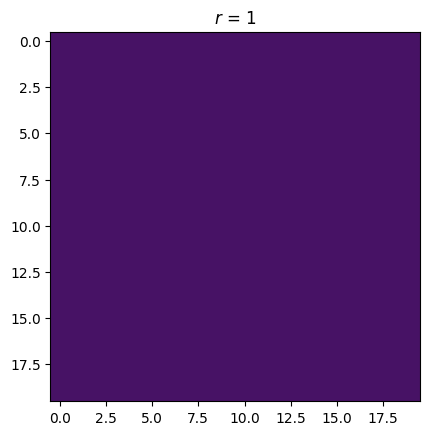

In [ ]:
n=20
ranks = jnp.array([-1,15,10,8,6,5,4,3,2,1])
anim = plot_lr_anim(n, ranks)